<h1> Training <code>`color_saturation`</code> </h1>

**Labels:**
* color_saturation_desaturated
* color_saturation_neutral
* color_saturation_pastel
* color_saturation_saturated

In [ ]:
# Dynamically load package
%load_ext autoreload
%autoreload 2

# Display multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger

from CinemaNet.convert import torch_to_coreml
from CinemaNet.blend import *
from CinemaNet.wandb import *
from CinemaNet.custom_head import *
from CinemaNet.train_utils import to_film_ar # other utils will be redefined for clarity

import wandb

In [ ]:
model_name = 'cat_color-saturation_MNetV2-150x266'

In [ ]:
wandb.init(name    = f"{re.sub('cat_[a-z].*_', '', model_name)}",
           project = 'color_saturation',
           entity  = 'synopsis',
           reinit  = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


W&B Run: https://app.wandb.ai/synopsis/color_saturation/runs/9d6vh1e3

In [ ]:
%env WANDB_NOTEBOOK_NAME='cat_color-saturation.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_color-saturation.ipynb'


## Creating Train + Val Datasets

In [ ]:
path = '/home/rahul/datasets/Synopsis_Model_All_Concepts/color_saturation/'

### Viewing the frequency distribution of the labels in a random 20% split

In [ ]:
# presort + seed = full reproducibility on _any_ machine
img_list = ImageList.from_folder(path, presort=True)
data_split = img_list.split_by_rand_pct(0.2, seed=1234)

In [ ]:
len(data_split.train.items)

1709

In [ ]:
regex = {
    'color_saturation_desaturated' : '\/color_saturation_desaturated/',
    'color_saturation_neutral': '\/color_saturation_neutral/',
    'color_saturation_pastel': '\/color_saturation_pastel/',
    'color_saturation_saturated' : '\/color_saturation_saturated/',
}

In [ ]:
# train_split

fnames_all   = list(data_split.train.items)
count        = {}
train_fnames = {}
samples_per_label = 2000


for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
pd.DataFrame([count]).T

,0
color_saturation_desaturated,763
color_saturation_neutral,399
color_saturation_pastel,196
color_saturation_saturated,351


In [ ]:
# val_split

fnames_all   = list(data_split.valid.items)
count        = {}
train_fnames = {}
samples_per_label = 100

for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
pd.DataFrame([count]).T

,0
color_saturation_desaturated,100
color_saturation_neutral,85
color_saturation_pastel,50
color_saturation_saturated,89


### Create With Specific # of Samples per Label

Rounding off the # of validation samples for easier metrics interpretation

In [ ]:
n_desaturated = 200
n_neutral     = 100
n_pastel      = 50
n_saturated   = 100


In [ ]:
regex

{'color_saturation_desaturated': '\\/color_saturation_desaturated/',
 'color_saturation_neutral': '\\/color_saturation_neutral/',
 'color_saturation_pastel': '\\/color_saturation_pastel/',
 'color_saturation_saturated': '\\/color_saturation_saturated/'}

In [ ]:
# val_split

img_list = ImageList.from_folder(path, presort=True)
np.random.seed(1234)
np.random.shuffle(img_list.items)
fnames_all   = list(img_list.items)
count        = {}
valid_fnames = {}
samples_per_label = 100

for key in regex:
    i=0
    valid_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            valid_fnames[key].append(f)
            # refactor -- can't put it into a function
            if key == 'color_saturation_desaturated':
                if i >= n_desaturated: break;
            if key == 'color_saturation_neutral':     
                if i >= n_neutral: break;
            if key == 'color_saturation_pastel': 
                if i >= n_pastel: break;
            if key == 'color_saturation_saturated':
                if i >= n_saturated: break;
                    
count

{'color_saturation_desaturated': 200,
 'color_saturation_neutral': 100,
 'color_saturation_pastel': 50,
 'color_saturation_saturated': 100}

In [ ]:
# sanity check
len(valid_fnames['color_saturation_desaturated'])
len(valid_fnames['color_saturation_neutral'])
len(valid_fnames['color_saturation_pastel'])
len(valid_fnames['color_saturation_saturated'])

200

100

50

100

In [ ]:
fnames_valid = sum(valid_fnames.values(),[])
fnames_train = list(set(fnames_all) - set(fnames_valid))

In [ ]:
len(fnames_train)

1686

In [ ]:
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))
lls

LabelLists;

Train: ImageList (1686 items)
Image (3, 551, 1024),Image (3, 470, 960),Image (3, 596, 900),Image (3, 449, 549),Image (3, 700, 700)
Path: .;

Valid: ImageList (450 items)
Image (3, 400, 600),Image (3, 683, 1023),Image (3, 750, 750),Image (3, 403, 604),Image (3, 651, 980)
Path: .;

Test: None

In [ ]:
img_size   = to_film_ar(150)
batch_size = 64

In [ ]:
data = (lls
        .label_from_folder()
        .transform(tfms=get_transforms(),
                   size=img_size,
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (1686 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
color_saturation_saturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_pastel,color_saturation_pastel
Path: .;

Valid: LabelList (450 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated,color_saturation_desaturated
Path: .;

Test: None

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
vc

color_saturation_desaturated    766
color_saturation_neutral        384
color_saturation_pastel         196
color_saturation_saturated      340
dtype: int64

In [ ]:
vc = pd.value_counts(data.valid_ds.y.items, sort=False)
vc.index = data.classes
vc

color_saturation_desaturated    200
color_saturation_neutral        100
color_saturation_pastel          50
color_saturation_saturated      100
dtype: int64

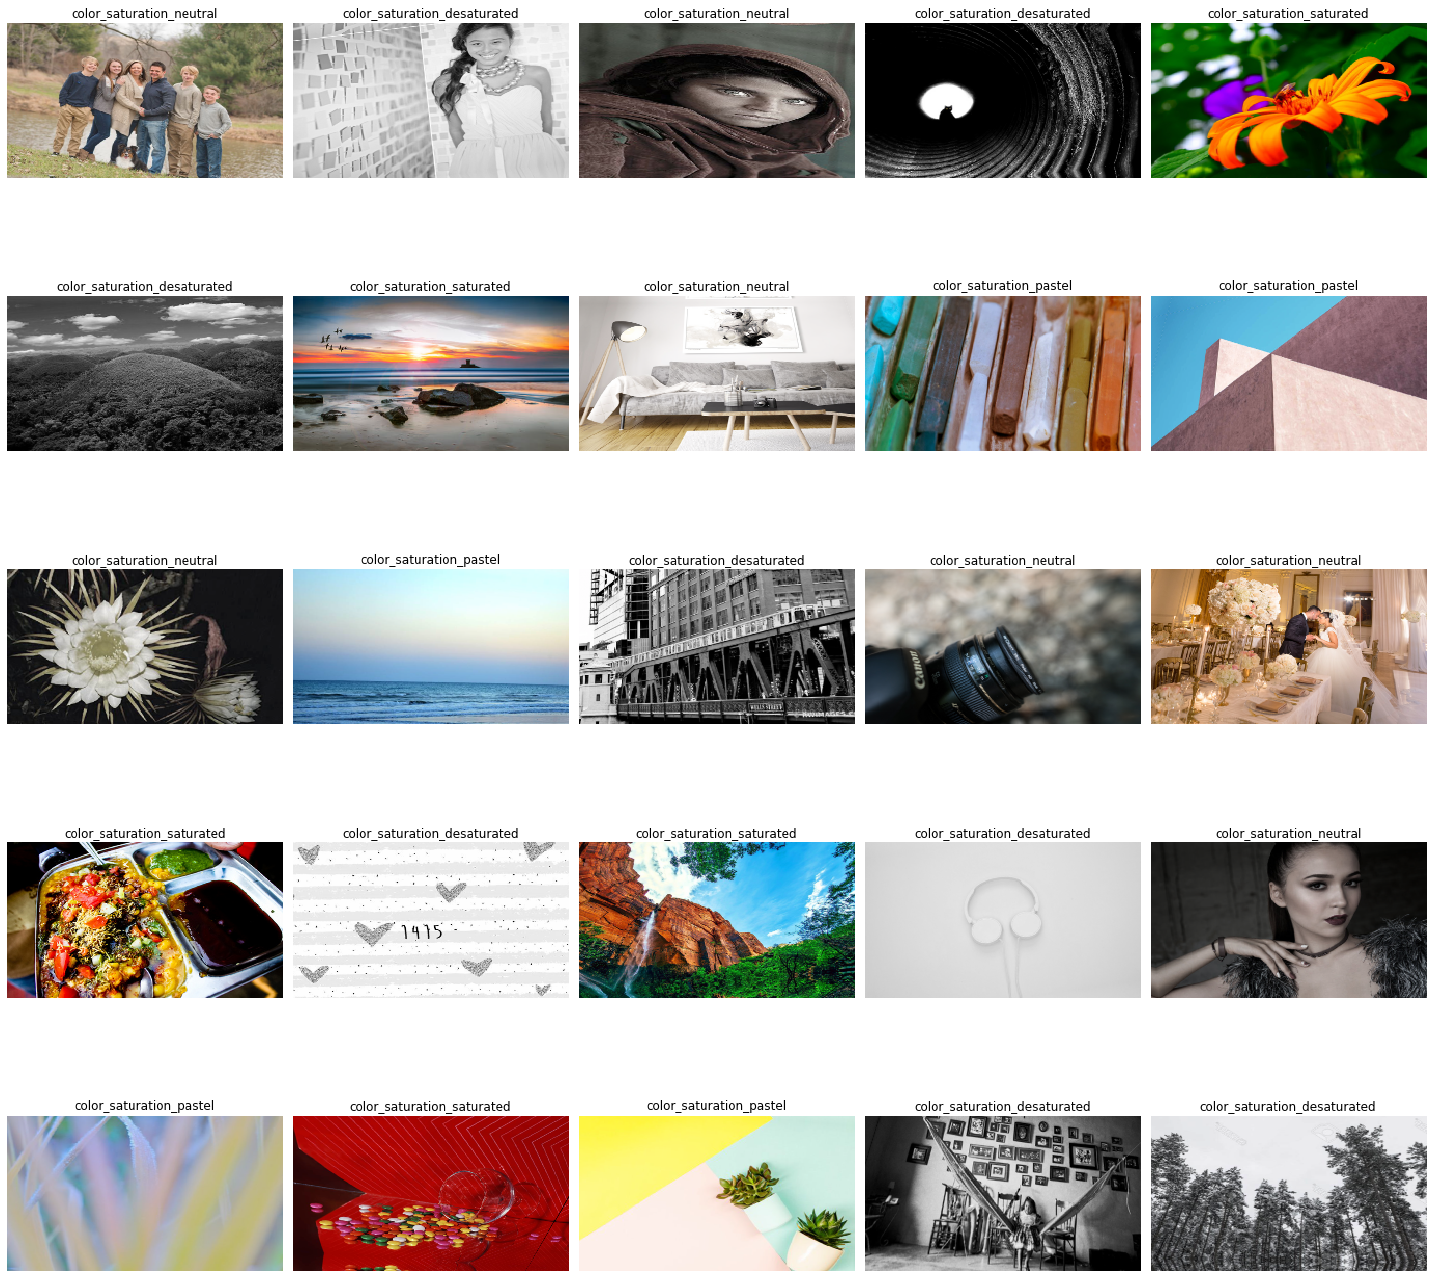

In [ ]:
data.show_batch()

## Model Setup

### Architecture, Loss Function, Optimiser

In [ ]:
arch = models.mobilenet_v2
loss_func = LabelSmoothingCrossEntropy()
opt_func  = Ranger

In [ ]:
model_name

'cat_color-saturation_MNetV2-150x266'

In [ ]:
metrics = [accuracy, FBeta()]

def get_callbacks(learner, mod_name, monitor='accuracy'):
    return [
        SaveModelCallback(learner, name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

### Data Augmentations

`CutMix` is generally known to give better performance than `MixUp` (tentative), but this can be contextual.

Intuitively, `CutMix` is a good choice here, since you don't need to see the entire image to classify it. In the case of `shot_framing`, `MixUp` would be a better choice

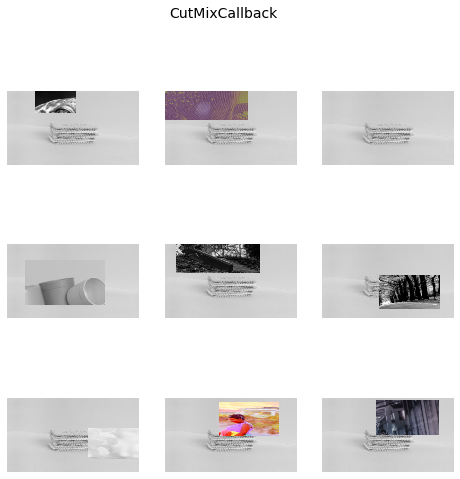

In [ ]:
_ = Learner(data,arch()).cutmix().show_tfms()

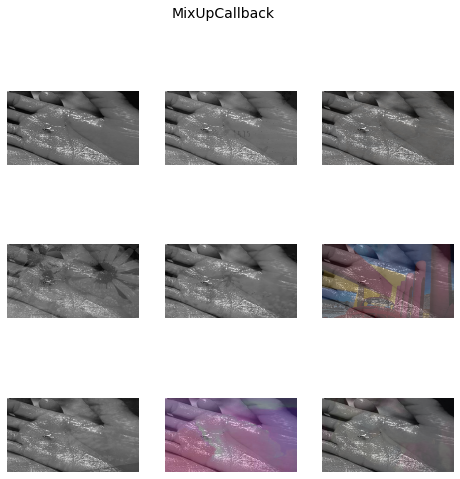

In [ ]:
_ = Learner(data,arch()).mixup().show_tfms()

### Model

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func, callback_fns=callbacks)
learn = learn.cutmix()

## Training

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.cutmix()

In [ ]:
learn.save(model_name)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 3.31E-03


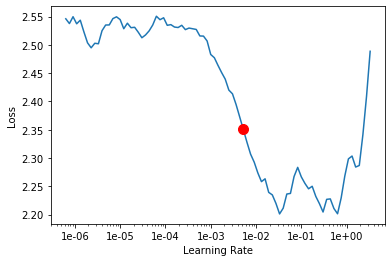

In [ ]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [ ]:
model_name
callbacks = get_callbacks(learn, model_name)

'cat_color-saturation_MNetV2-150x266'

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.964231,0.875722,0.733333,0.678701,00:11
1,1.701630,0.807278,0.802222,0.742161,00:09
2,1.528652,0.806215,0.793333,0.740526,00:09
3,1.446008,0.726478,0.813333,0.756571,00:09
4,1.338921,0.695107,0.848889,0.769610,00:09
5,1.265283,0.649063,0.866667,0.814290,00:09
6,1.163560,0.648793,0.880000,0.841394,00:09
7,1.117161,0.643752,0.866667,0.816503,00:09
8,1.070214,0.619747,0.877778,0.832404,00:09
9,1.021270,0.602409,0.882222,0.833076,00:09


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7333333492279053.
Better model found at epoch 0 with accuracy value: 0.7333333492279053.
Better model found at epoch 1 with accuracy value: 0.8022222518920898.
Better model found at epoch 1 with accuracy value: 0.8022222518920898.
Better model found at epoch 3 with accuracy value: 0.8133333325386047.
Better model found at epoch 3 with accuracy value: 0.8133333325386047.
Better model found at epoch 4 with accuracy value: 0.8488888740539551.
Better model found at epoch 4 with accuracy value: 0.8488888740539551.
Better model found at epoch 5 with accuracy value: 0.8666666746139526.
Better model found at epoch 5 with accuracy value: 0.8666666746139526.
Better model found at epoch 6 with accuracy value: 0.8799999952316284.
Better model found at epoch 6 with accuracy value: 0.8799999952316284.
Better model found at epoch 9 with accuracy value: 0.8822222352027893.
Better model found at epoch 9 with accuracy value: 0.8822222352027893.
set st

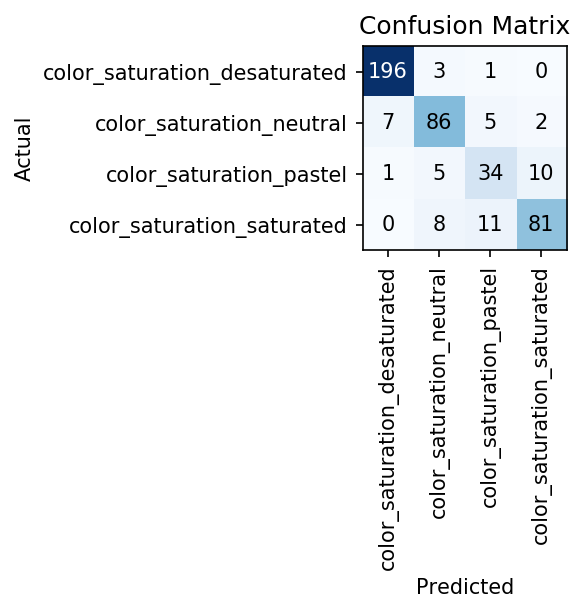

In [ ]:
learn.fit_fc(10, 5e-3, wd=1e-2, callbacks=callbacks)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.63E-04


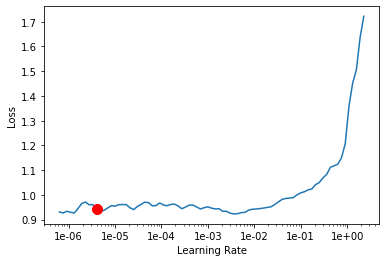

In [ ]:
learn.unfreeze()
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [ ]:
model_name
model_name2 = f'{model_name}-unfrozen'
model_name2

'cat_color-saturation_MNetV2-150x266'

'cat_color-saturation_MNetV2-150x266-unfrozen'

In [ ]:
callbacks = get_callbacks(learn, model_name2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.962304,0.604928,0.880000,0.827872,00:09
1,0.920536,0.583555,0.891111,0.843938,00:09
2,0.974506,0.586151,0.877778,0.840075,00:09
3,0.960512,0.573849,0.897778,0.851652,00:10
4,0.946520,0.571013,0.902222,0.863423,00:11
5,0.921403,0.565588,0.902222,0.867478,00:11
6,0.903303,0.570614,0.891111,0.842776,00:11
7,0.886285,0.552079,0.897778,0.857023,00:11
8,0.873952,0.544012,0.906667,0.872215,00:11
9,0.843801,0.544934,0.908889,0.872500,00:12


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.8799999952316284.
Better model found at epoch 0 with accuracy value: 0.8799999952316284.


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with accuracy value: 0.8911111354827881.
Better model found at epoch 1 with accuracy value: 0.8911111354827881.
Better model found at epoch 3 with accuracy value: 0.897777795791626.
Better model found at epoch 3 with accuracy value: 0.897777795791626.
Better model found at epoch 4 with accuracy value: 0.902222216129303.
Better model found at epoch 4 with accuracy value: 0.902222216129303.
Better model found at epoch 8 with accuracy value: 0.9066666960716248.
Better model found at epoch 8 with accuracy value: 0.9066666960716248.
Better model found at epoch 9 with accuracy value: 0.9088888764381409.
Better model found at epoch 9 with accuracy value: 0.9088888764381409.
Better model found at epoch 12 with accuracy value: 0.9133333563804626.
Better model found at epoch 12 with accuracy value: 0.9133333563804626.
Better model found at epoch 14 with accuracy value: 0.9244444370269775.
Better model found at epoch 14 with accuracy value: 0.9244444370269775.
Better

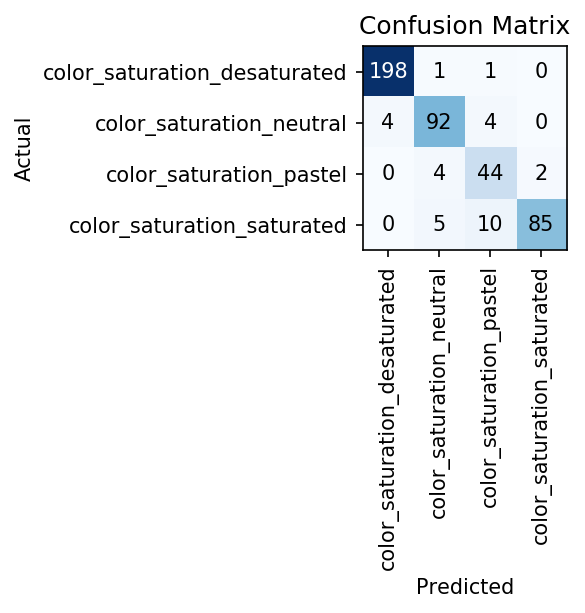

In [ ]:
learn.fit_fc(25, lr=1e-3, wd=1e-2, callbacks=callbacks)

In [ ]:
interpret = learn.interpret()

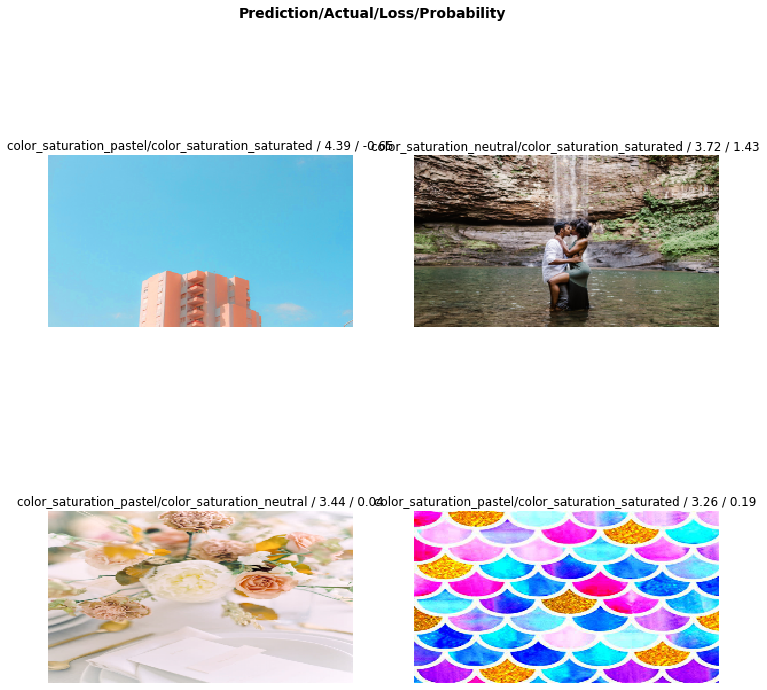

In [ ]:
interpret.plot_top_losses(4)

In [ ]:
interpret.most_confused()

[('color_saturation_saturated', 'color_saturation_pastel', 10),
 ('color_saturation_saturated', 'color_saturation_neutral', 5),
 ('color_saturation_neutral', 'color_saturation_desaturated', 4),
 ('color_saturation_neutral', 'color_saturation_pastel', 4),
 ('color_saturation_pastel', 'color_saturation_neutral', 4),
 ('color_saturation_pastel', 'color_saturation_saturated', 2),
 ('color_saturation_desaturated', 'color_saturation_neutral', 1),
 ('color_saturation_desaturated', 'color_saturation_pastel', 1)]

In [ ]:
learn.load(model_name2);

set state called


In [ ]:
model_name
model_name2

'cat_color-saturation_MNetV2-150x266'

'cat_color-saturation_MNetV2-150x266-unfrozen'

In [ ]:
torch_to_coreml(learn.model, data.c, model_fname=model_name2, img_size=img_size)

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Converting Node Type Add
26/162: Converting Node Type Conv


In [ ]:
model_name2

'cat_color-saturation_MNetV2-150x266-unfrozen'

In [ ]:
!ls -l ../exported-models/{model_name2}*

-rw-rw-r-- 1 rahul rahul 14342744 Jan 27 00:30 ../exported-models/cat_color-saturation_MNetV2-150x266-unfrozen.mlmodel
-rw-rw-r-- 1 rahul rahul 14353213 Jan 27 00:29 ../exported-models/cat_color-saturation_MNetV2-150x266-unfrozen.onnx


In [ ]:
wandb.save(f'../exported-models/{model_name2}*')

['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200126_183754-9d6vh1e3/cat_color-saturation_MNetV2-150x266-unfrozen.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200126_183754-9d6vh1e3/cat_color-saturation_MNetV2-150x266-unfrozen.mlmodel']

wandb: Network error resolved after 0:00:11.542906, resuming normal operation.
wandb: Network error resolved after 0:00:16.889996, resuming normal operation.
